### Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Supported Device: {device}")

# import torch.nn.functional as F
import pandas as pd
# from einops import rearrange

Supported Device: cpu


### Helper Functions

In [4]:
def proceess_data(data:str, keys:str) -> tuple:
    features = []
    lines = data.split("\n")
    for line in lines:
        features.append(list(map(float, line.split("\t"))))

    np_features = np.array(features).T[::-1,:]
    # print(np_features)
    xscaler = StandardScaler().fit(np_features[:, :-2])
    yscaler = StandardScaler().fit(np_features[:, -2:])
    scaled_features =  np.hstack([xscaler.transform(np_features[:,:-2]),yscaler.transform(np_features[:, -2:])])
    return yscaler, scaled_features

### Data Processing  (Berkshire Hathaway Data)

In [21]:
data = """129619	126401	97322	103869	92774	76332	74803	67145	58535	79209	101760	85385	63822	118906	110518	94623	81506	53378	77745	88029
23758	22435	22353	22566	25128	18602	21136	21718	16434	18125	20460	20027	18685	19435	19210	17923	19898	19172	19962	19415
353842	318621	353409	328161	308793	306167	327662	390538	350719	310739	307942	282097	248027	245317	207454	180782	172757	220051	200516	191771
29066	27496	27493	26403	28050	28714	17494	17596	17375	16658	16542	16533	17505	17152	17132	17583	17325	17535	17208	17308
24681	24009	23530	23144	23208	22094	21877	21265	20751	20397	19900	19449	17527	18584	18175	17660	16280	17135	16807	16432
199646	195214	193160	190181	181381	177850	177288	176722	176364	174123	173652	172789	159276	161539	159902	158522	152408	156556	154719	146599
16947	16284	16028	15674	15584	15139	15125	15038	14918	14752	14659	14567	15065	14714	14887	14899	14298	14934	14741	14429
84626	85652	85853	83502	78119	73395	73618	73822	73875	73770	73758	73695	81882	71865	71753	81659	81025	81228	81269	81220
145729	143743	143451	143020	142887	128308	125794	125369	124920	125475	123195	121646	115460	119827	117506	115631	110292	113361	112330	111168
30507	31914	31173	30359	28657	26878	25727	25368	23512	25239	23732	23756	19782	22018	20992	21718	18093	20764	20113	20172
20213	18556	19635	19937	22421	22305	22562	22673	22452	22409	22106	21709	20155	20975	20642	20193	18632	19422	19155	18918
128271	124781	125347	123624	122744	116496	119081	119661	114262	114965	115223	114531	103368	107691	106689	104233	97490	102194	89907	97193
54863	55077	52233	52525	50116	47971	47580	46005	46072	48132	45544	43693	42319	44026	40665	39614	37186	41189	40588	39807
34480	34473	35140	35156	35167	35190	35204	35586	35592	35603	35635	35630	35658	35621	35615	35619	35707	35612	35610	35622
607350	569776	582543	546631	511602	493438	496126	539881	534421	494775	484431	456337	402493	408791	738654	352359	321112	373334	356846	342773
-76802	-74655	-73568	-72265	-67826	-64972	-63934	-62906	-59795	-53072	-45446	-39418	-8125	-24075	-14815	-9700	-3109	-5937	-5252	-4799
542625	531477	517810	465600	468711	406470	408950	528921	450662	411379	418601	385702	347815	320001	267300	272000	339590	311832	318350	301215
356.660004	350.299988	341	308.769989	308.899994	267.019989	273.019989	352.910004	299	272.940002	277.920013	255.470001	231.869995	212.940002	178.509995	182.830002	226.5	208.020004	213.169998	200.89"""

In [22]:
keys = """Short-term investment in U.S. Treasury Bills
FIxed Maturity Securities
Equity Securities
Equity Method Investments
Loans Receiveables
Property, Plant and Equipment
Equipment held for lease/ Service model
Goodwill
Unpaid Losses
Unearned Premiums
Life, Annuity and Insuarance Benefits
Notes payable and other borrowings
Accounts payable
Capital in excess of par value
Retained earnings
Treasury stock, at cost
BRK-A
BRK-B"""

In [23]:
scaler, np_scaled_features = proceess_data(data, keys)
print(np_scaled_features.shape)

(20, 18)


### KT Estimator

In [158]:
class KTEstimator():
    def __init__(self, data:np.array = np_scaled_features, K = 4, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False
        self.scaler = scaler
        offset = 1 # Manipulating train-test split to accomodate at least one slab of (K+T) observation in test-set
        train_set, test_set = data[:int(len(data)*train_size)-offset], data[int(len(data)*train_size)-offset:]  
        # Creating Train Feature - Label Matrix        
        train_D = np.zeros(shape=(train_set.shape[1], train_set.shape[0]-(K+T)+1, K))
        train_L = np.zeros(shape=(train_set.shape[0]-(K+T)+1, 2))
        for i in range(train_D.shape[1]):
            train_D[:,i,:] = train_set[i:i+K, :].T
            train_L[i] = train_set[i+K:i+K+T, -2:]
        
        # print(len(train_set), len(test_set))
        # Creating Test Feature - Label Matrix        
        test_D = np.zeros(shape=(test_set.shape[1], test_set.shape[0]-(K+T)+1, K))
        test_L = np.zeros(shape=(test_set.shape[0]-(K+T)+1, 2))
        for i in range(test_D.shape[1]):
            test_D[:,i,:] = test_set[i:i+K, :].T
            test_L[i] = test_set[i+K:i+K+T, -2:]
        
        # print(train_D.shape, test_D.shape)
        X_train = np.zeros(shape = (train_D.shape[1], train_set.shape[1] * K))
        X_test = np.zeros(shape = (test_D.shape[1], test_set.shape[1] * K))

        for i in range(X_train.shape[0]):
            X_train[i] = np.concatenate([arr for arr in train_D[:,i,:]])

        for i in range(X_test.shape[0]):
            X_test[i] = np.concatenate([arr for arr in test_D[:,i,:]])
        
        
        # Test Train Split
        X_train = torch.tensor(X_train, dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(train_L,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(test_L,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test, self.train_D, self.train_L, self.test_D, self.test_L = X_train, X_test, y_train, y_test, train_D, train_L, test_D, test_L

        return None
    
    def fit(self, model, convergence:float = 1e-7, num_epochs:int = 2000, batch_size:int = 4, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []
        print(f"Training Tensor shape: {self.X_train.shape}, Testing Tensor shape: {self.X_test.shape}\n")
        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target)
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs\n')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        self.istrained = True
        return None
    
    def predict(self, model):
        loss_fn = nn.MSELoss()
        # Trained Model Prediction
        predictions = []
        test_losses = []
        with torch.no_grad():
            test_indices = np.arange(0, len(self.X_test))
            for i in test_indices:
                y = model(self.X_test[i])
                loss = loss_fn(y, self.y_test[i])
                predictions.append(np.hstack([scaler.inverse_transform(y.numpy().reshape(1,-1))[0], scaler.inverse_transform(self.y_test[i].numpy().reshape(1,-1))[0]]))
                test_losses.append(loss)
        self.predictions = np.array(predictions)
        self.test_losses = test_losses
        return None

Multilayer Perceptron

In [160]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_size1, hidden_size2, hidden_size3, output_dim):
    super(MLP, self).__init__()
    self.lin1 = nn.Linear(input_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, hidden_size3)
    self.lin4 = nn.Linear(hidden_size3, output_dim)
  
  def forward(self, x):
    y1 = self.lin1(x)
    y2 = torch.relu(y1)
    y3 = self.lin2(y2)
    y4 = torch.relu(y3)
    y5 = self.lin3(y4)
    y6 = torch.relu(y5)
    y = self.lin4(y6)
    return y

Using `KTEstimator` to make predictions

In [154]:
#Trained Model Prediction
K = 2
T = 1
train_size = 0.70
hidden_size1 = 25
hidden_size2 = 12
hidden_size3 = 5
runs = 20
convergence = 1e-7
num_epochs = 2000
batch_size = 6
lr = 0.01

predictions1 = [] # *****
predictions2 = [] # *****
for i in range(runs):
    print(f"============================= RUN {i+1} =============================")
    est = KTEstimator(np_scaled_features, K, T, train_size)
    model = MLP(input_dim = est.X_train.shape[1], hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, hidden_size3 = hidden_size3, output_dim = 2)
    est.fit(model, convergence, num_epochs, batch_size, lr)
    est.predict(model)
    predictions1.append(est.predictions[:,0])
    predictions2.append(est.predictions[:,1])
predictions1 = np.array(predictions1)
predictions2 = np.array(predictions2)

============================= RUN 1 =============================
Training Tensor shape: torch.Size([11, 36]), Testing Tensor shape: torch.Size([5, 36])

Epoch: 0 | Loss: 0.16245725479992953
Final Training Loss: 6.0822457519613884e-05
Converged after 57 epochs

============================= RUN 2 =============================
Training Tensor shape: torch.Size([11, 36]), Testing Tensor shape: torch.Size([5, 36])

Epoch: 0 | Loss: 0.2092740535736084
Final Training Loss: 0.00016603342109275135
Converged after 47 epochs

============================= RUN 3 =============================
Training Tensor shape: torch.Size([11, 36]), Testing Tensor shape: torch.Size([5, 36])

Epoch: 0 | Loss: 0.17304321852597324
Epoch: 100 | Loss: 3.903212663400072e-05
Final Training Loss: 3.8157753641082145e-05
Converged after 104 epochs

============================= RUN 4 =============================
Training Tensor shape: torch.Size([11, 36]), Testing Tensor shape: torch.Size([5, 36])

Epoch: 0 | Loss: 0.

Plotting the predictions

In [155]:
# For BRK A
avg_pred_1 = np.mean(predictions1, axis = 0)
med_pred_1 = np.median(predictions1, axis = 0)

# For BRK B
avg_pred_2 = np.mean(predictions2, axis = 0)
med_pred_2 = np.median(predictions2, axis = 0)

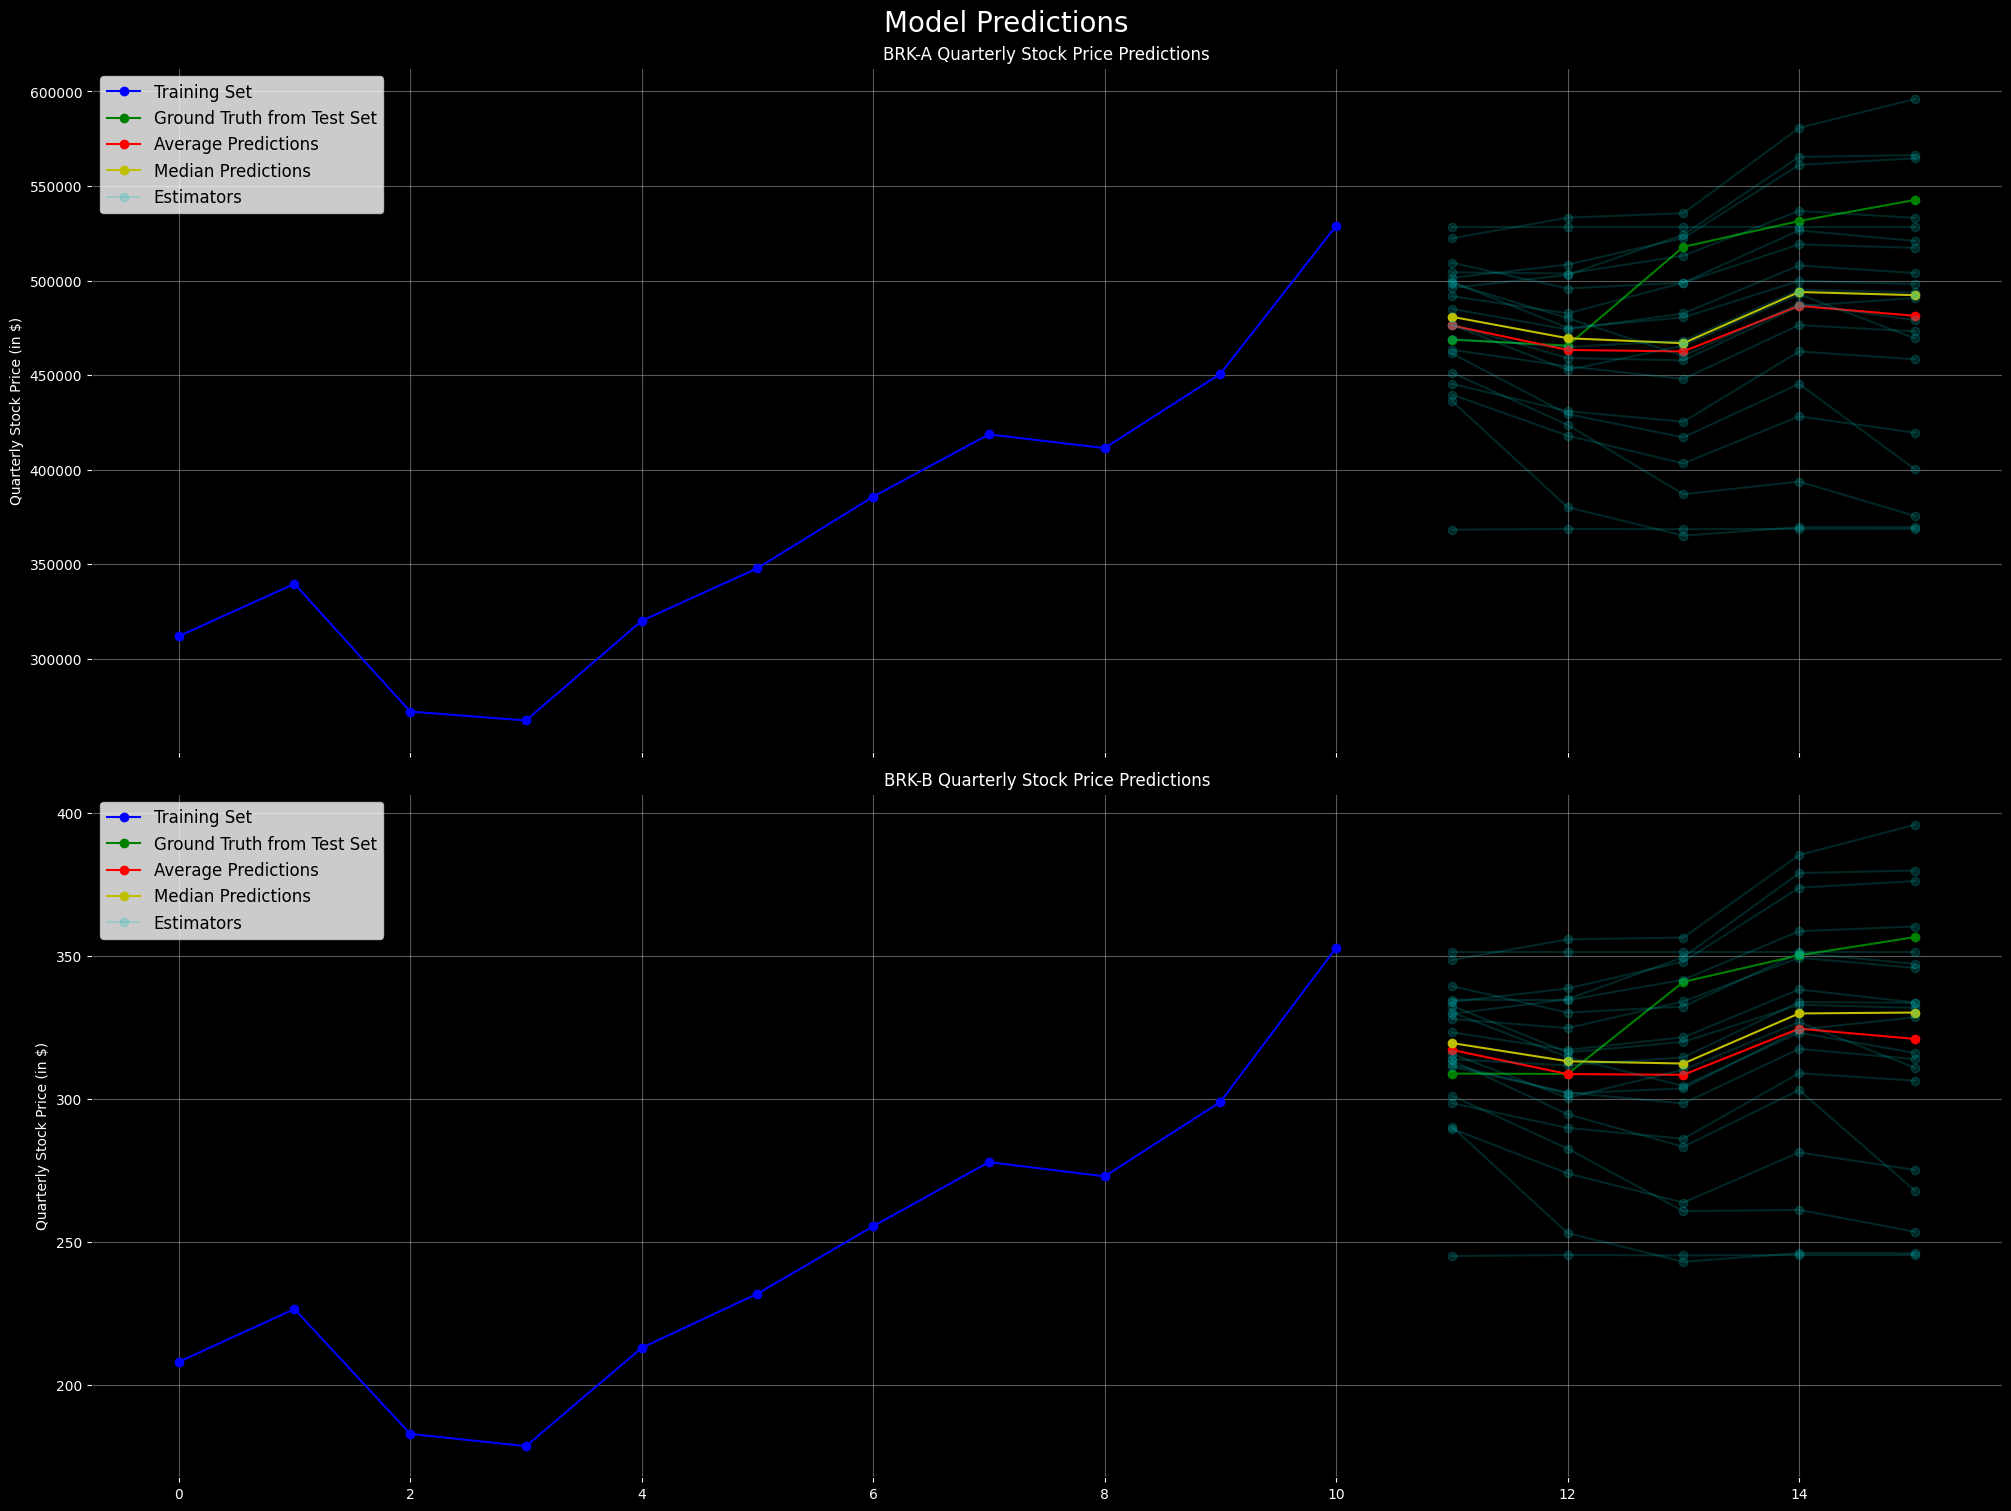

In [156]:
fig, ax = plt.subplots(2, 1, figsize = (20,15), sharex=True, layout  = "constrained")
plt.suptitle("Model Predictions", fontsize = 20, color = 'white')
fig.patch.set_facecolor('#000000')
ax[0].set_title("BRK-A Quarterly Stock Price Predictions", color = 'white')
ax[0].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
ax[0].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 0], 'b-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 0], 'g-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_1, 'r-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_1, 'y-o')
for i in range(runs):
    ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions1[i], 'c-o', alpha = 0.2)
ax[0].legend(["Training Set", "Ground Truth from Test Set", "Average Predictions", "Median Predictions", "Estimators"], fontsize = 12)
ax[0].grid(alpha = 0.5)
ax[0].set_facecolor('#000000')
ax[0].tick_params(axis='both', colors='white')

ax[1].set_title("BRK-B Quarterly Stock Price Predictions", color = 'white')
ax[1].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
ax[1].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 1], 'b-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 1], 'g-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_2, 'r-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_2, 'y-o')
for i in range(runs):
    ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions2[i], 'c-o', alpha = 0.2)
ax[1].legend(["Training Set", "Ground Truth from Test Set", "Average Predictions", "Median Predictions","Estimators"], fontsize = 12)
ax[1].grid(alpha = 0.5)
ax[1].set_facecolor('#000000')
ax[1].tick_params(axis='both', colors='white')
plt.show()

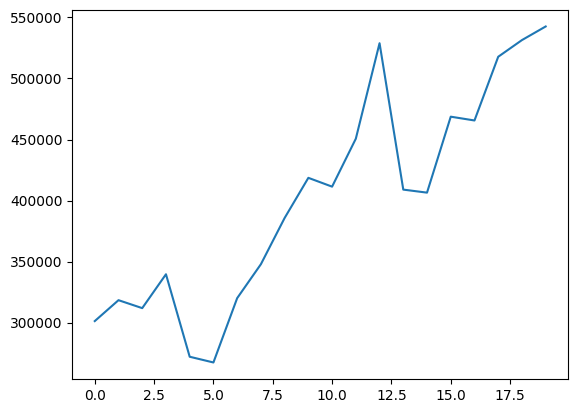

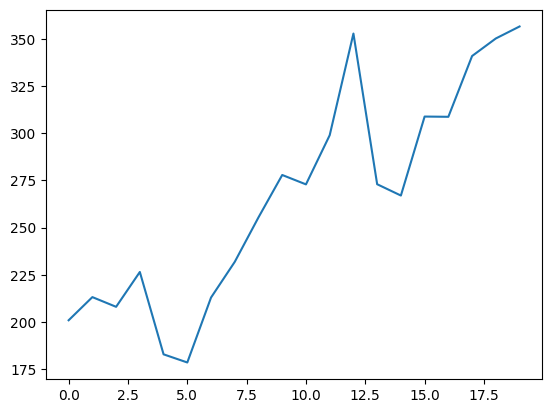

In [72]:
features1 = scaler.inverse_transform(np_scaled_features[:, -2:])[:,0]
features2 = scaler.inverse_transform(np_scaled_features[:, -2:])[:,1]
plt.plot(features1)
plt.plot(features2)

Model paramaters

In [128]:
for child in model.children():
    print(f"Weights: {child.weight}")
    print(f"Bias: {child.bias}")

torch.Size([25, 36])
torch.Size([12, 25])
torch.Size([5, 12])
torch.Size([2, 5])


In [157]:
scaler.inverse_transform(est.test_L), predictions1, predictions2

(array([[4.68711000e+05, 3.08899994e+02],
        [4.65600000e+05, 3.08769989e+02],
        [5.17810000e+05, 3.41000000e+02],
        [5.31477000e+05, 3.50299988e+02],
        [5.42625000e+05, 3.56660004e+02]]),
 array([[461479.8 , 429326.38, 417069.3 , 445326.97, 400207.34],
        [504342.75, 503685.66, 513160.1 , 536834.7 , 533144.94],
        [476651.84, 459005.9 , 457771.03, 486423.94, 490802.5 ],
        [436300.7 , 380096.7 , 365055.66, 369565.28, 369553.7 ],
        [469173.8 , 464877.88, 468145.9 , 495124.22, 493713.88],
        [491728.1 , 482649.1 , 498867.78, 519136.22, 517285.7 ],
        [499270.88, 474984.44, 480509.25, 499799.78, 498194.4 ],
        [528158.75, 528158.75, 528158.75, 528158.75, 528158.75],
        [496088.7 , 502950.8 , 524264.  , 565380.8 , 566346.6 ],
        [445319.6 , 430931.22, 425302.22, 462485.44, 458364.6 ],
        [368206.75, 368629.7 , 368464.34, 368629.7 , 368629.7 ],
        [439681.66, 417937.16, 403242.62, 428148.8 , 419506.5 ],
        

### KT Estimator (Model 2)

In [159]:
class KTEstimator():
    def __init__(self, data:np.array = np_scaled_features, K = 4, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False
        self.scaler = scaler
        offset = 1 # Manipulating train-test split to accomodate at least one slab of (K+T) observation in test-set
        train_set, test_set = data[:int(len(data)*train_size)-offset], data[int(len(data)*train_size)-offset:]  
        # Creating Train Feature - Label Matrix        
        train_D = np.zeros(shape=(train_set.shape[1], train_set.shape[0]-(K+T)+1, K))
        train_L = np.zeros(shape=(train_set.shape[0]-(K+T)+1, 2))
        for i in range(train_D.shape[1]):
            train_D[:,i,:] = train_set[i:i+K, :].T
            train_L[i] = train_set[i+K-1, -2:]
        
        # print(len(train_set), len(test_set))
        # Creating Test Feature - Label Matrix        
        test_D = np.zeros(shape=(test_set.shape[1], test_set.shape[0]-(K+T)+1, K))
        test_L = np.zeros(shape=(test_set.shape[0]-(K+T)+1, 2))
        for i in range(test_D.shape[1]):
            test_D[:,i,:] = test_set[i:i+K, :].T
            test_L[i] = test_set[i+K-1, -2:]
        
        # print(train_D.shape, test_D.shape)
        X_train = np.zeros(shape = (train_D.shape[1], train_set.shape[1] * K))
        X_test = np.zeros(shape = (test_D.shape[1], test_set.shape[1] * K))

        for i in range(X_train.shape[0]):
            X_train[i] = np.concatenate([arr for arr in train_D[:,i,:]])

        for i in range(X_test.shape[0]):
            X_test[i] = np.concatenate([arr for arr in test_D[:,i,:]])
        
        
        # Test Train Split
        X_train = torch.tensor(X_train[:, :-2], dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(train_L,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test[:, :-2],dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(test_L,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test, self.train_D, self.train_L, self.test_D, self.test_L = X_train, X_test, y_train, y_test, train_D, train_L, test_D, test_L

        return None
    
    def fit(self, model, convergence:float = 1e-7, num_epochs:int = 2000, batch_size:int = 4, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []
        print(f"Training Tensor shape: {self.X_train.shape}, Testing Tensor shape: {self.X_test.shape}\n")
        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target)
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs\n')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        self.istrained = True
        return None
    
    def predict(self, model):
        loss_fn = nn.MSELoss()
        # Trained Model Prediction
        predictions = []
        test_losses = []
        with torch.no_grad():
            test_indices = np.arange(0, len(self.X_test))
            for i in test_indices:
                y = model(self.X_test[i])
                loss = loss_fn(y, self.y_test[i])
                predictions.append(np.hstack([scaler.inverse_transform(y.numpy().reshape(1,-1))[0], scaler.inverse_transform(self.y_test[i].numpy().reshape(1,-1))[0]]))
                test_losses.append(loss)
        self.predictions = np.array(predictions)
        self.test_losses = test_losses
        return None

In [175]:
#Trained Model Prediction
K = 4
T = 1
train_size = 0.70
hidden_size1 = 25
hidden_size2 = 12
hidden_size3 = 5
runs = 20
convergence = 1e-7
num_epochs = 2000
batch_size = 6
lr = 0.01

predictions1 = [] # *****
predictions2 = [] # *****
for i in range(runs):
    print(f"============================= RUN {i+1} =============================")
    est = KTEstimator(np_scaled_features, K, T, train_size)
    model = MLP(input_dim = est.X_train.shape[1], hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, hidden_size3 = hidden_size3, output_dim = 2)
    est.fit(model, convergence, num_epochs, batch_size, lr)
    est.predict(model)
    predictions1.append(est.predictions[:,0])
    predictions2.append(est.predictions[:,1])
predictions1 = np.array(predictions1)
predictions2 = np.array(predictions2)

============================= RUN 1 =============================
Training Tensor shape: torch.Size([9, 70]), Testing Tensor shape: torch.Size([3, 70])

Epoch: 0 | Loss: 0.13925119241078696
Epoch: 100 | Loss: 2.7722941619382862e-05
Final Training Loss: 1.0948657796284857e-05
Converged after 133 epochs

============================= RUN 2 =============================
Training Tensor shape: torch.Size([9, 70]), Testing Tensor shape: torch.Size([3, 70])

Epoch: 0 | Loss: 0.13449703322516549
Epoch: 100 | Loss: 5.445205735870534e-05
Final Training Loss: 4.2640350430802855e-06
Converged after 163 epochs

============================= RUN 3 =============================
Training Tensor shape: torch.Size([9, 70]), Testing Tensor shape: torch.Size([3, 70])

Epoch: 0 | Loss: 0.23092708985010782
Epoch: 100 | Loss: 0.09139531685246362
Epoch: 200 | Loss: 0.1129107375939687
Epoch: 300 | Loss: 0.09109601544009314
Epoch: 400 | Loss: 0.09482310877905951
Epoch: 500 | Loss: 0.10655458768208821
Epoch: 60

In [176]:
# For BRK A
avg_pred_1 = np.mean(predictions1, axis = 0)
med_pred_1 = np.median(predictions1, axis = 0)

# For BRK B
avg_pred_2 = np.mean(predictions2, axis = 0)
med_pred_2 = np.median(predictions2, axis = 0)

In [179]:
scaler.inverse_transform(est.test_L), avg_pred_1, med_pred_1

(array([[4.65600000e+05, 3.08769989e+02],
        [5.17810000e+05, 3.41000000e+02],
        [5.31477000e+05, 3.50299988e+02]]),
 array([404977.66, 398595.44, 387852.94], dtype=float32),
 array([407844.7, 395840.3, 383435.3], dtype=float32))

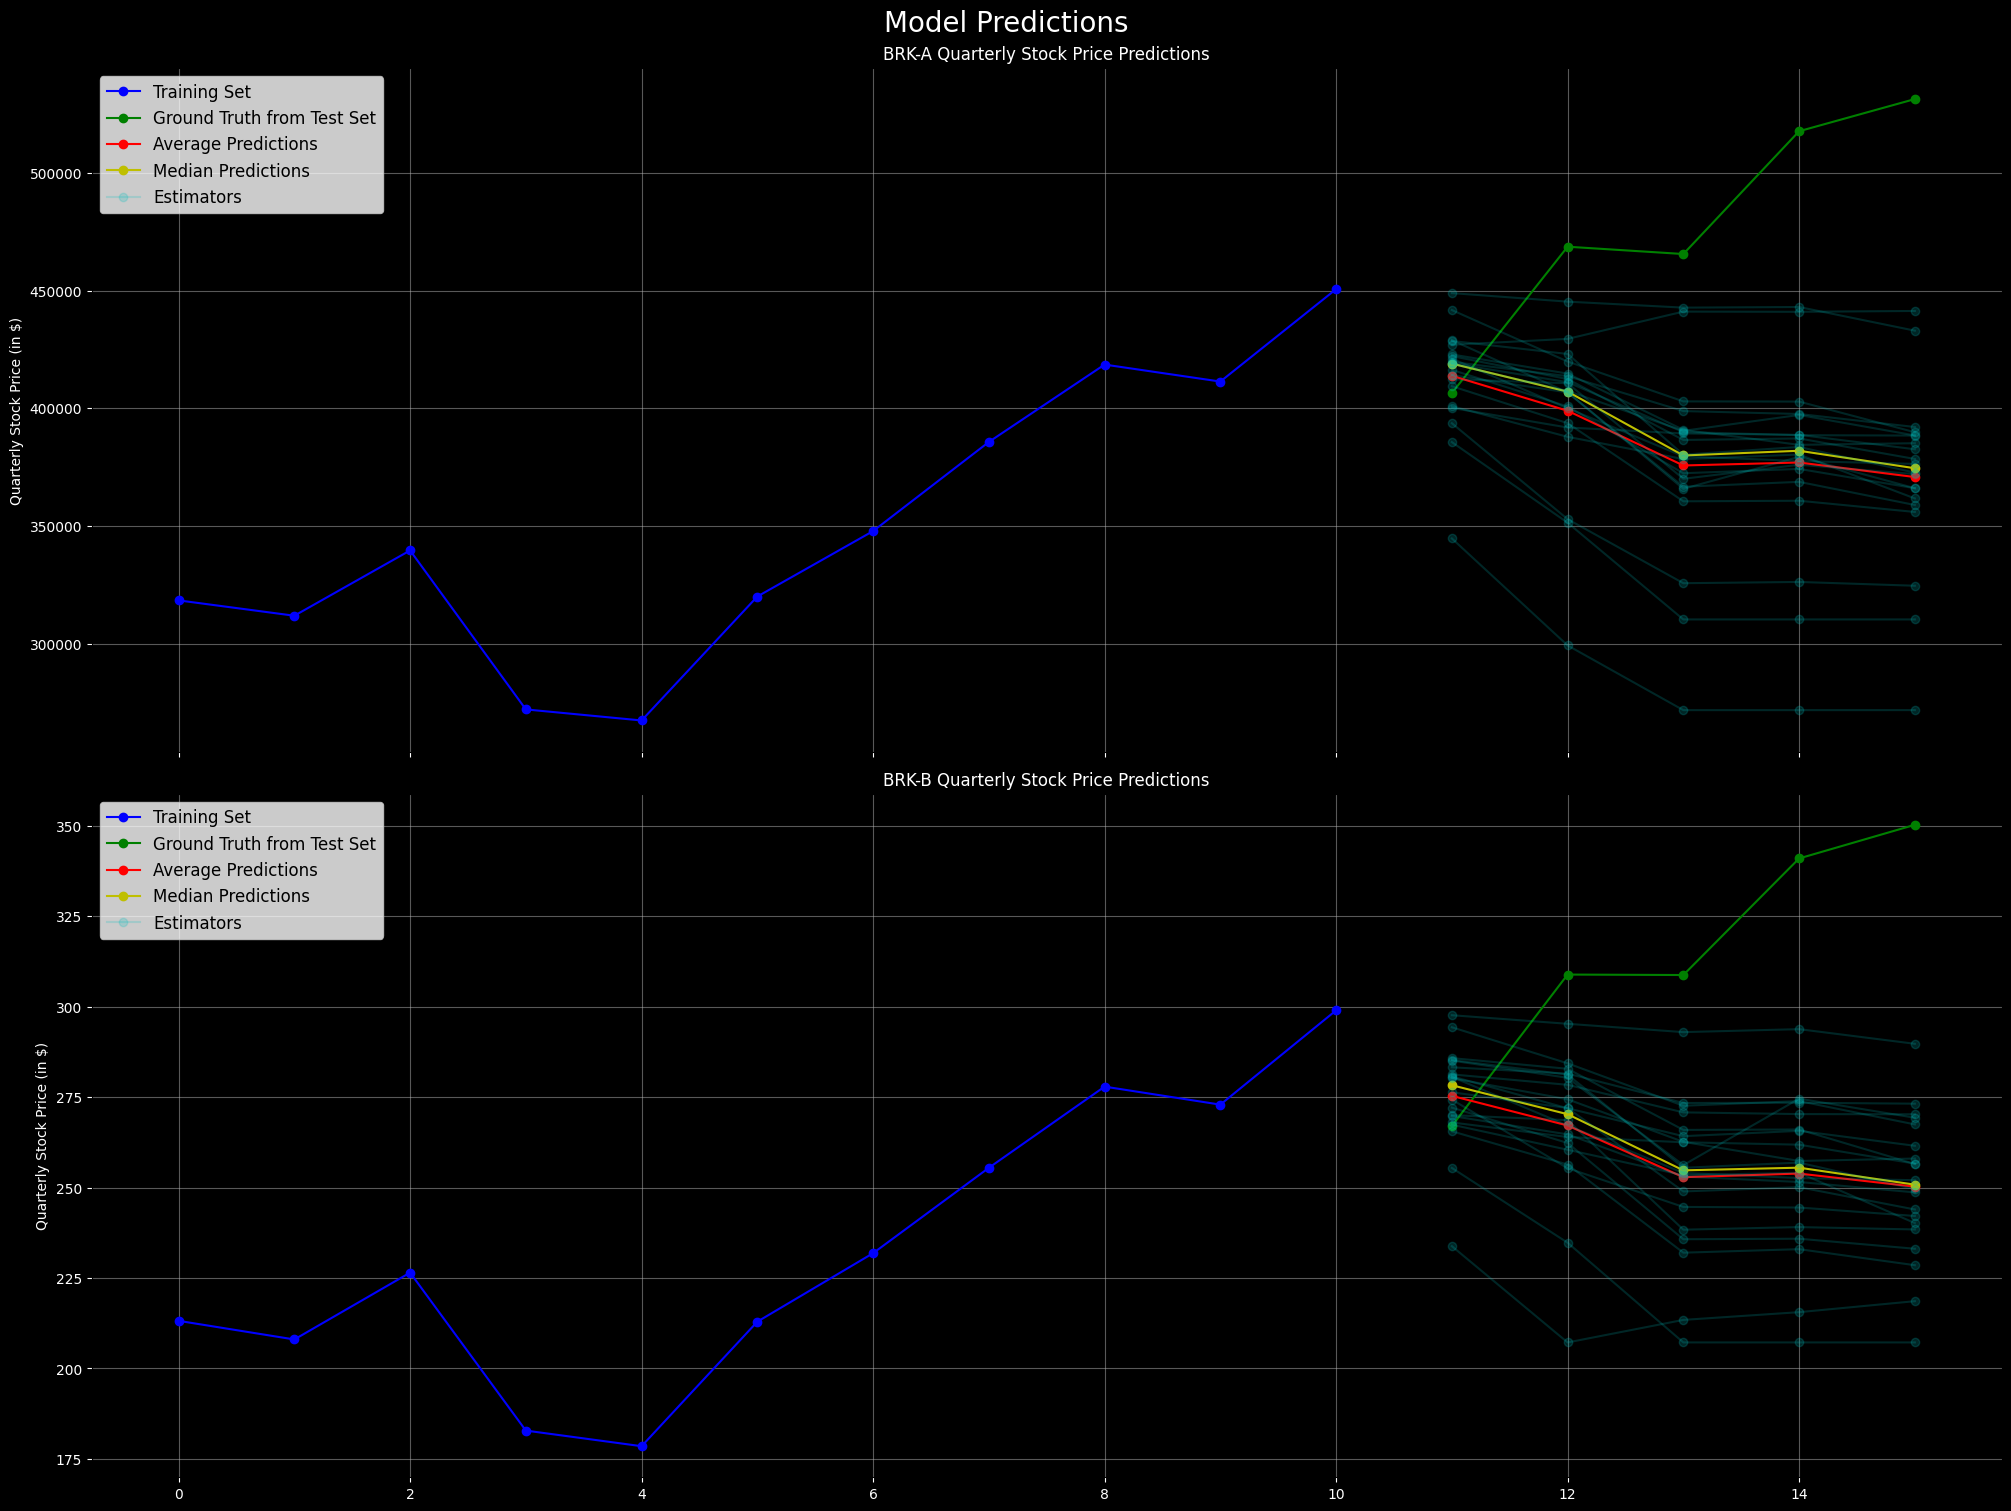

In [171]:
fig, ax = plt.subplots(2, 1, figsize = (20,15), sharex=True, layout  = "constrained")
plt.suptitle("Model Predictions", fontsize = 20, color = 'white')
fig.patch.set_facecolor('#000000')
ax[0].set_title("BRK-A Quarterly Stock Price Predictions", color = 'white')
ax[0].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
ax[0].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 0], 'b-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 0], 'g-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_1, 'r-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_1, 'y-o')
for i in range(runs):
    ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions1[i], 'c-o', alpha = 0.2)
ax[0].legend(["Training Set", "Ground Truth from Test Set", "Average Predictions", "Median Predictions", "Estimators"], fontsize = 12)
ax[0].grid(alpha = 0.5)
ax[0].set_facecolor('#000000')
ax[0].tick_params(axis='both', colors='white')

ax[1].set_title("BRK-B Quarterly Stock Price Predictions", color = 'white')
ax[1].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
ax[1].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 1], 'b-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 1], 'g-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_2, 'r-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_2, 'y-o')
for i in range(runs):
    ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions2[i], 'c-o', alpha = 0.2)
ax[1].legend(["Training Set", "Ground Truth from Test Set", "Average Predictions", "Median Predictions","Estimators"], fontsize = 12)
ax[1].grid(alpha = 0.5)
ax[1].set_facecolor('#000000')
ax[1].tick_params(axis='both', colors='white')
plt.show()

### KT Estimator (Model 3)

In [5]:
data = """129619	126401	97322	103869	92774	76332	74803	67145	58535	79209	101760	85385	63822	118906	110518	94623	81506	53378	77745	88029
23758	22435	22353	22566	25128	18602	21136	21718	16434	18125	20460	20027	18685	19435	19210	17923	19898	19172	19962	19415
353842	318621	353409	328161	308793	306167	327662	390538	350719	310739	307942	282097	248027	245317	207454	180782	172757	220051	200516	191771
29066	27496	27493	26403	28050	28714	17494	17596	17375	16658	16542	16533	17505	17152	17132	17583	17325	17535	17208	17308
24681	24009	23530	23144	23208	22094	21877	21265	20751	20397	19900	19449	17527	18584	18175	17660	16280	17135	16807	16432
199646	195214	193160	190181	181381	177850	177288	176722	176364	174123	173652	172789	159276	161539	159902	158522	152408	156556	154719	146599
16947	16284	16028	15674	15584	15139	15125	15038	14918	14752	14659	14567	15065	14714	14887	14899	14298	14934	14741	14429
84626	85652	85853	83502	78119	73395	73618	73822	73875	73770	73758	73695	81882	71865	71753	81659	81025	81228	81269	81220
145729	143743	143451	143020	142887	128308	125794	125369	124920	125475	123195	121646	115460	119827	117506	115631	110292	113361	112330	111168
30507	31914	31173	30359	28657	26878	25727	25368	23512	25239	23732	23756	19782	22018	20992	21718	18093	20764	20113	20172
20213	18556	19635	19937	22421	22305	22562	22673	22452	22409	22106	21709	20155	20975	20642	20193	18632	19422	19155	18918
128271	124781	125347	123624	122744	116496	119081	119661	114262	114965	115223	114531	103368	107691	106689	104233	97490	102194	89907	97193
54863	55077	52233	52525	50116	47971	47580	46005	46072	48132	45544	43693	42319	44026	40665	39614	37186	41189	40588	39807
34480	34473	35140	35156	35167	35190	35204	35586	35592	35603	35635	35630	35658	35621	35615	35619	35707	35612	35610	35622
607350	569776	582543	546631	511602	493438	496126	539881	534421	494775	484431	456337	402493	408791	738654	352359	321112	373334	356846	342773
-76802	-74655	-73568	-72265	-67826	-64972	-63934	-62906	-59795	-53072	-45446	-39418	-8125	-24075	-14815	-9700	-3109	-5937	-5252	-4799
93466	93120	92503	85393	78165	76934	76180	70810	71907	70583	69114	64599	64450	63024	56840	61265	65368	64972	63598	60678
36814	-29778	33061	34758	14473	-13465	-66919	-1978	40527	4921	27394	5700	-101196	31582	40085	70275	31311	10926	10048	20322
30580	31049	30621	30319	31609	31292	31633	29785	29863	28984	28761	26530	23526	25957	26216	25392	27277	26950	27047	25767
6878	5120	5005	5602	7425	4068	3762	4251	4999	4889	5045	3910	5505	5181	4652	4471	5677	4384	4829	4432
83764	80653	80640	76087	71232	68027	64974	62396	63592	63397	60934	56022	58725	56966	61259	54339	26479	56053	56011	53521
26124	-8824	24775	24337	12349	-1832	-29754	3702	26452	6882	18488	7638	22013	18994	16314	-30653	17892	10119	8608	13209
5.62	5.88	16.52	16.25	8.23	-1.22	-19.84	2.47	17.63	4.59	12.33	5.09	14.68	12.66	10.88	-20.44	11.92	6.75	5.74	8.81
38083	-12799	36648	35580	19807	-4747	-45502	5059	40317	9729	28581	11384	36782	30914	27049	-51224	29324	15794	14122	21949
10.17	8.99	99.46	91.24	90.78	52.87	7.377	8.95	8.06	6.14	6.33	14.26	15.28	23.1	19.6	5.515	6.819	18.84	18.26	18
25990	-8824	24775	24377	12274	-1907	-29663	3784	26529	6882	18488	7638	22508	18994	16314	-30653	17884	10119	8608	13209
0.2285	0.2375	0.2322	0.245	0.2593	0.2558	0.2582	0.2355	0.2257	0.2594	0.2711	0.2805	0.2638	0.2594	0.2711	0.2805	0.2433	0.247	0.2612	0.2635
17.81	14.79	17.28	1.49	-4.71	-0.21	2.44	16.83	18.63	18.42	23.43	24.12	10.35	8.85	5.55	2.52	20.49	7.1	7.75	7.32
9.32	7.66	8.92	0.76	-2.44	-0.11	1.29	8.91	9.79	9.58	12.09	12.32	5.23	4.49	2.82	1.28	10.49	3.59	3.93	3.71
5.2	5.2	4.7	4.5	4.5	4.9	4.7	4.3	4.3	4.2	4.2	2.7	3.7	3.9	4.4	4.8	4.7	4.9	4.9	5.1
4.3	4.2	3.8	5	3.44	0.5	4.8	3.6	3.7	3.5	3.4	2.2	3	3.1	3.4	4.2	3.9	4.1	4.1	4.3
34.9	29.2	34.42	4.52	-7.62	1.7	7.61	40.06	43.73	43.51	54.58	61.26	30.37	26.65	19.15	7.44	43.04	17.27	18.52	17.45
542625	531477	517810	465600	468711	406470	408950	528921	450662	411379	418601	385702	347815	320001	267300	272000	339590	311832	318350	301215
356.660004	350.299988	341	308.769989	308.899994	267.019989	273.019989	352.910004	299	272.940002	277.920013	255.470001	231.869995	212.940002	178.509995	182.830002	226.5	208.020004	213.169998	200.89"""


In [6]:
keys = """Short-term investment in U.S. Treasury Bills
FIxed Maturity Securities
Equity Securities
Equity Method Investments
Loans Receiveables
Property, Plant and Equipment
Equipment held for lease/ Service model
Goodwill
Unpaid Losses
Unearned Premiums
Life, Annuity and Insuarance Benefits
Notes payable and other borrowings
Accounts payable
Capital in excess of par value
Retained earnings
Treasury stock, at cost
Total Revenue
Investment and derivative contract gains
Cost of Sales and Services
Selling, general and administrative expenses
Total Costs and Expense
ne per class A share
ne per class B share
Comprehensive income - BH shareholders
P/E Ratio
Diluted EPS
D/E ratio
ROE (%)
ROA (%)
ROCE (%) (A)
ROIC (%)
Operating Margin
BRK-A
BRK-B"""

In [7]:
scaler, np_scaled_features = proceess_data(data, keys)
print(np_scaled_features.shape)

(20, 34)


In [8]:
class KTEstimator():
    def __init__(self, data:np.array = np_scaled_features, K = 4, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False
        self.scaler = scaler
        offset = 1 # Manipulating train-test split to accomodate at least one slab of (K+T) observation in test-set
        train_set, test_set = data[:int(len(data)*train_size)-offset], data[int(len(data)*train_size)-offset:]  
        # Creating Train Feature - Label Matrix        
        train_D = np.zeros(shape=(train_set.shape[1], train_set.shape[0]-(K+T)+1, K))
        train_L = np.zeros(shape=(train_set.shape[0]-(K+T)+1, 2))
        for i in range(train_D.shape[1]):
            train_D[:,i,:] = train_set[i:i+K, :].T
            train_L[i] = train_set[i+K:i+K+T, -2:]
        
        # print(len(train_set), len(test_set))
        # Creating Test Feature - Label Matrix        
        test_D = np.zeros(shape=(test_set.shape[1], test_set.shape[0]-(K+T)+1, K))
        test_L = np.zeros(shape=(test_set.shape[0]-(K+T)+1, 2))
        for i in range(test_D.shape[1]):
            test_D[:,i,:] = test_set[i:i+K, :].T
            test_L[i] = test_set[i+K:i+K+T, -2:]
        
        # print(train_D.shape, test_D.shape)
        X_train = np.zeros(shape = (train_D.shape[1], train_set.shape[1] * K))
        X_test = np.zeros(shape = (test_D.shape[1], test_set.shape[1] * K))

        for i in range(X_train.shape[0]):
            X_train[i] = np.concatenate([arr for arr in train_D[:,i,:]])

        for i in range(X_test.shape[0]):
            X_test[i] = np.concatenate([arr for arr in test_D[:,i,:]])
        
        
        # Test Train Split
        X_train = torch.tensor(X_train, dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(train_L,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(test_L,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test, self.train_D, self.train_L, self.test_D, self.test_L = X_train, X_test, y_train, y_test, train_D, train_L, test_D, test_L

        return None
    
    def fit(self, model, convergence:float = 1e-7, num_epochs:int = 2000, batch_size:int = 4, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []
        print(f"Training Tensor shape: {self.X_train.shape}, Testing Tensor shape: {self.X_test.shape}\n")
        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target)
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs\n')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        self.istrained = True
        return None
    
    def predict(self, model):
        loss_fn = nn.MSELoss()
        # Trained Model Prediction
        predictions = []
        test_losses = []
        with torch.no_grad():
            test_indices = np.arange(0, len(self.X_test))
            for i in test_indices:
                y = model(self.X_test[i])
                loss = loss_fn(y, self.y_test[i])
                predictions.append(np.hstack([scaler.inverse_transform(y.numpy().reshape(1,-1))[0], scaler.inverse_transform(self.y_test[i].numpy().reshape(1,-1))[0]]))
                test_losses.append(loss)
        self.predictions = np.array(predictions)
        self.test_losses = test_losses
        return None

In [9]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_size1, hidden_size2, hidden_size3, output_dim):
    super(MLP, self).__init__()
    self.lin1 = nn.Linear(input_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, hidden_size3)
    self.lin4 = nn.Linear(hidden_size3, output_dim)
  
  def forward(self, x):
    y1 = self.lin1(x)
    y2 = torch.relu(y1)
    y3 = self.lin2(y2)
    y4 = torch.relu(y3)
    y5 = self.lin3(y4)
    y6 = torch.relu(y5)
    y = self.lin4(y6)
    return y

In [10]:
#Trained Model Prediction
K = 2
T = 1
train_size = 0.70
hidden_size1 = 25
hidden_size2 = 12
hidden_size3 = 5
runs = 20
convergence = 1e-7
num_epochs = 2000
batch_size = 6
lr = 0.01

predictions1 = [] # *****
predictions2 = [] # *****
for i in range(runs):
    print(f"============================= RUN {i+1} =============================")
    est = KTEstimator(np_scaled_features, K, T, train_size)
    model = MLP(input_dim = est.X_train.shape[1], hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, hidden_size3 = hidden_size3, output_dim = 2)
    est.fit(model, convergence, num_epochs, batch_size, lr)
    est.predict(model)
    predictions1.append(est.predictions[:,0])
    predictions2.append(est.predictions[:,1])
predictions1 = np.array(predictions1)
predictions2 = np.array(predictions2)

============================= RUN 1 =============================
Training Tensor shape: torch.Size([11, 68]), Testing Tensor shape: torch.Size([5, 68])

Epoch: 0 | Loss: 0.19259580698880283
Epoch: 100 | Loss: 4.488923877943307e-05
Final Training Loss: 3.36157576053996e-05
Converged after 115 epochs

============================= RUN 2 =============================
Training Tensor shape: torch.Size([11, 68]), Testing Tensor shape: torch.Size([5, 68])

Epoch: 0 | Loss: 0.17925021865151144
Final Training Loss: 5.191035721839977e-06
Converged after 93 epochs

============================= RUN 3 =============================
Training Tensor shape: torch.Size([11, 68]), Testing Tensor shape: torch.Size([5, 68])

Epoch: 0 | Loss: 0.18180588700554587
Epoch: 100 | Loss: 0.018877063623883507
Final Training Loss: 0.021125140176578003
Converged after 173 epochs

============================= RUN 4 =============================
Training Tensor shape: torch.Size([11, 68]), Testing Tensor shape: tor

In [11]:
# For BRK A
avg_pred_1 = np.mean(predictions1, axis = 0)
med_pred_1 = np.median(predictions1, axis = 0)

# For BRK B
avg_pred_2 = np.mean(predictions2, axis = 0)
med_pred_2 = np.median(predictions2, axis = 0)

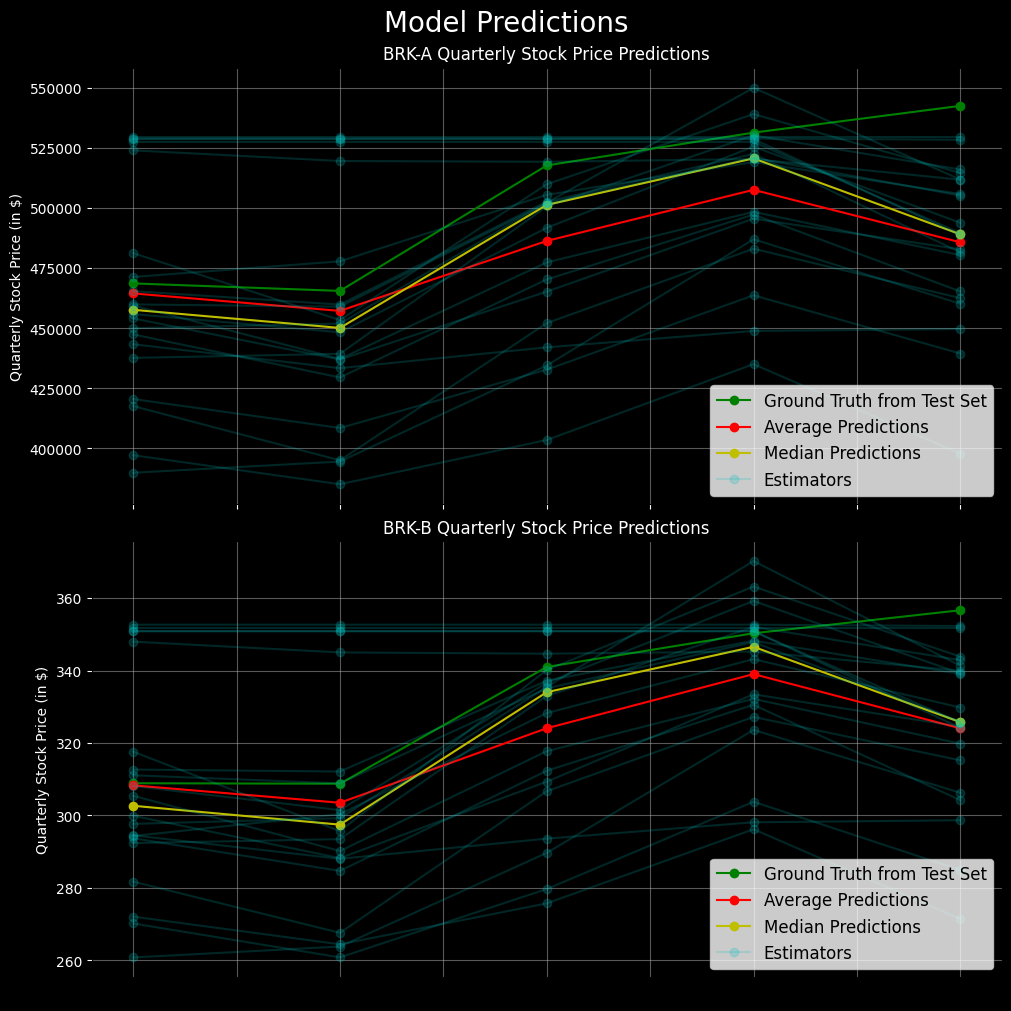

In [12]:
fig, ax = plt.subplots(2, 1, figsize = (10,10), sharex=True, layout  = "constrained")
plt.suptitle("Model Predictions", fontsize = 20, color = 'white')
fig.patch.set_facecolor('#000000')
ax[0].set_title("BRK-A Quarterly Stock Price Predictions", color = 'white')
ax[0].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
# ax[0].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 0], 'b-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 0], 'g-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_1, 'r-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_1, 'y-o')
for i in range(runs):
    ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions1[i], 'c-o', alpha = 0.2)
ax[0].legend(["Ground Truth from Test Set", "Average Predictions", "Median Predictions", "Estimators"], fontsize = 12)
ax[0].grid(alpha = 0.5)
ax[0].set_facecolor('#000000')
ax[0].tick_params(axis='both', colors='white')

ax[1].set_title("BRK-B Quarterly Stock Price Predictions", color = 'white')
ax[1].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
# ax[1].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 1], 'b-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 1], 'g-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_2, 'r-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_2, 'y-o')
for i in range(runs):
    ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions2[i], 'c-o', alpha = 0.2)
ax[1].legend(["Ground Truth from Test Set", "Average Predictions", "Median Predictions","Estimators"], fontsize = 12)
ax[1].grid(alpha = 0.5)
ax[1].set_facecolor('#000000')
ax[1].tick_params(axis='y', colors='white')
plt.show()

In [13]:
dataframe = pd.DataFrame({"Ground Truth BRK-A": scaler.inverse_transform(est.test_L)[:, 0], "Ground Truth BRK-B": scaler.inverse_transform(est.test_L)[:, 1], "Average Prediction BRK-A":avg_pred_1, "Average Prediction BRK-B":avg_pred_2, "Median Prediction BRK-A":med_pred_1, "Median Prediction BRK-B":med_pred_2})
dataframe.to_csv("Results.csv")

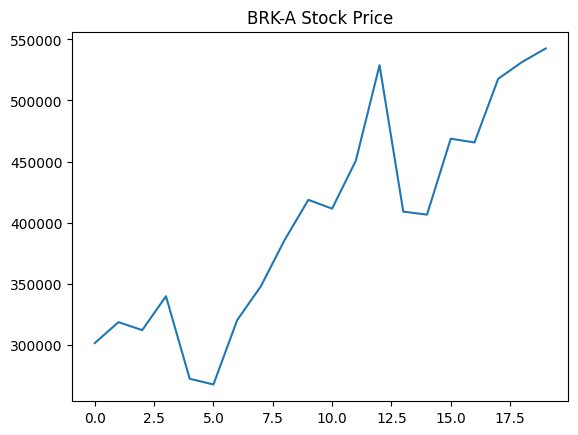

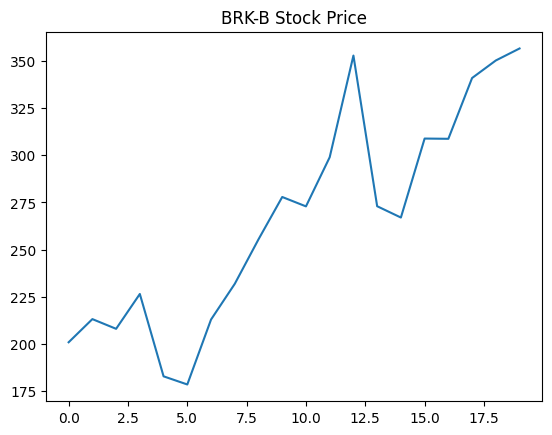

In [14]:
features1 = scaler.inverse_transform(np_scaled_features[:, -2:])[:,0]
features2 = scaler.inverse_transform(np_scaled_features[:, -2:])[:,1]
plt.plot(features1)
plt.title("BRK-A Stock Price")
plt.figure()
plt.plot(features2)
plt.title("BRK-B Stock Price")
plt.show()

In [15]:
model

MLP(
  (lin1): Linear(in_features=68, out_features=25, bias=True)
  (lin2): Linear(in_features=25, out_features=12, bias=True)
  (lin3): Linear(in_features=12, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=2, bias=True)
)

### Model 4

In [264]:
data = '''4926.24	5014.31	5192.24	3050.54	5296.17	4552.15	4828.92	3119.95	2147.20	1838.74	1818.39	1560.30	1657.59	1550.28	1412.42	1764.42	1932.22	1993.21	2036.54	2169.83
4926.24	5014.31	5192.24	3050.54	5296.17	4552.15	4828.92	3119.95	2147.20	1838.74	1818.39	1560.30	1657.59	1550.28	1412.42	1764.42	1932.22	1993.21	2036.54	2169.83
183.88	184.05	190.43	224.31	181.16	163.79	176.91	219.32	158.66	162.21	156.67	184.08	154.14	158.87	152	152.28	156.66	154.5	147.27	194.12
284.32	286.65	289.88	301.82	288.65	286.39	290.61	287.26	147.32	149.75	146.65	169.96	168.31	167.37	163.25	172.18	188.45	162.07	163.05	160.57
3845.59	3809.80	3772.58	628.2	4204.24	4192.31	4543.90	2648.56	1444.18	1178.91	1121.50	345.83	1003.51	931.24	199.21	274.57	234.14	231.71	230.27	311.39
612.45	733.81	939.35	94.63	622.12	-90.34	-182.5	-35.19	397.04	347.87	393.57	183.73	331.63	292.8	339.93	439.97	550.9	616.4	628.77	487.08
469.26	234.42	443.43	482.51	1730.25	1151.02	721.61	1896.29	54.94	526.12	426.49	226.62	699.87	232.38	90.09	86.14	1.32	121.07	374.09	99.62
1081.71	968.23	1382.78	577.14	2352.37	1060.68	539.11	1861.10	451.98	873.99	820.06	410.35	1031.50	525.18	430.02	526.11	552.22	737.47	1002.86	586.7
533.32	587.6	597.76	569.18	538.81	555.76	562.85	527.83	365.21	356.13	388.52	374.24	366.35	387.2	390.98	359.61	378.43	385.38	386.96	444.33
548.39	380.63	785.02	7.96	1813.56	504.92	-23.74	1333.27	86.77	517.86	431.54	36.11	665.15	137.98	39.04	166.5	173.79	352.09	615.9	142.37
136.85	81.19	-186.47	143.47	199.85	1023.77	441.18	-12.58	11.71	1577.38	-30.05	142.45	-112.33	104.06	56.15	-323.67	-176.66	-180.45	-276.97	-95.83
685.24	461.82	598.55	151.43	2013.41	1528.69	417.44	1320.69	98.48	2095.24	401.49	178.56	552.82	242.04	95.19	-157.17	-2.87	171.64	338.93	46.54
158.16	51.56	152.14	9.54	509.07	328.46	-4	-967.61	49.81	220.12	203.45	-67.67	63.35	77.81	27.48	-219.01	-23.61	11.52	23.28	-32.59
527.08	410.26	446.41	141.89	1504.34	1200.23	421.44	2288.30	48.67	1875.12	198.04	246.23	489.47	164.23	67.71	61.84	20.74	160.12	315.65	79.13
527.08	410.26	446.41	141.89	1504.34	1200.23	421.44	2288.30	48.67	1875.12	198.04	157	574.52	145	44.93	-309.94	6.94	154.61	296.51	53.86
319.56	319.56	319.56	319.56	319.56	319.56	319.56	319.56	319.56	319.56	319.56	319.56	319.56	319.56	270.5	270.5	270.5	270.5	270.5	270.5
1.33	1.28	1.4	0.45	4.7	3.75	1.32	7.16	0.15	5.86	0.53	0.36	1.66	0.36	0.01	-1.3	0.13	0.36	0.99	0.11
1.65	1.28	1.4	0.45	4.7	3.75	1.32	7.18	0.15	5.86	0.53	0.36	1.66	0.36	0.01	-1.3	0.13	0.36	0.99	0.11
330	260	220	190	200	220	208	242	220	153	120	105	76	54	48	32	56	60	67	65'''

In [265]:
scaler, np_scaled_features = proceess_data(data, keys)
print(np_scaled_features.shape)

(20, 19)


In [269]:
class KTEstimator():
    def __init__(self, data:np.array = np_scaled_features, K = 4, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False
        self.scaler = scaler
        offset = 1 # Manipulating train-test split to accomodate at least one slab of (K+T) observation in test-set
        train_set, test_set = data[:int(len(data)*train_size)-offset], data[int(len(data)*train_size)-offset:]  
        # Creating Train Feature - Label Matrix        
        train_D = np.zeros(shape=(train_set.shape[1], train_set.shape[0]-(K+T)+1, K))
        train_L = np.zeros(shape=(train_set.shape[0]-(K+T)+1, 1))
        for i in range(train_D.shape[1]):
            train_D[:,i,:] = train_set[i:i+K, :].T
            train_L[i] = train_set[i+K:i+K+T, -1:]
        
        # print(len(train_set), len(test_set))
        # Creating Test Feature - Label Matrix        
        test_D = np.zeros(shape=(test_set.shape[1], test_set.shape[0]-(K+T)+1, K))
        test_L = np.zeros(shape=(test_set.shape[0]-(K+T)+1, 1))
        for i in range(test_D.shape[1]):
            test_D[:,i,:] = test_set[i:i+K, :].T
            test_L[i] = test_set[i+K:i+K+T, -1:]
        
        # print(train_D.shape, test_D.shape)
        X_train = np.zeros(shape = (train_D.shape[1], train_set.shape[1] * K))
        X_test = np.zeros(shape = (test_D.shape[1], test_set.shape[1] * K))

        for i in range(X_train.shape[0]):
            X_train[i] = np.concatenate([arr for arr in train_D[:,i,:]])

        for i in range(X_test.shape[0]):
            X_test[i] = np.concatenate([arr for arr in test_D[:,i,:]])
        
        
        # Test Train Split
        X_train = torch.tensor(X_train, dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(train_L,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(test_L,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test, self.train_D, self.train_L, self.test_D, self.test_L = X_train, X_test, y_train, y_test, train_D, train_L, test_D, test_L

        return None
    
    def fit(self, model, convergence:float = 1e-7, num_epochs:int = 2000, batch_size:int = 4, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []
        print(f"Training Tensor shape: {self.X_train.shape}, Testing Tensor shape: {self.X_test.shape}\n")
        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target)
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs\n')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        self.istrained = True
        return None
    
    def predict(self, model):
        loss_fn = nn.MSELoss()
        # Trained Model Prediction
        predictions = []
        test_losses = []
        with torch.no_grad():
            test_indices = np.arange(0, len(self.X_test))
            for i in test_indices:
                y = model(self.X_test[i])
                loss = loss_fn(y, self.y_test[i])
                predictions.append(np.hstack([scaler.inverse_transform(y.numpy().reshape(1,-1))[0], scaler.inverse_transform(self.y_test[i].numpy().reshape(1,-1))[0]]))
                test_losses.append(loss)
        self.predictions = np.array(predictions)
        self.test_losses = test_losses
        return None

In [270]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_size1, hidden_size2, hidden_size3, output_dim):
    super(MLP, self).__init__()
    self.lin1 = nn.Linear(input_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, hidden_size3)
    self.lin4 = nn.Linear(hidden_size3, output_dim)
  
  def forward(self, x):
    y1 = self.lin1(x)
    y2 = torch.relu(y1)
    y3 = self.lin2(y2)
    y4 = torch.relu(y3)
    y5 = self.lin3(y4)
    y6 = torch.relu(y5)
    y = self.lin4(y6)
    return y

In [273]:
#Trained Model Prediction
K = 2
T = 1
train_size = 0.70
hidden_size1 = 25
hidden_size2 = 12
hidden_size3 = 5
runs = 20
convergence = 1e-7
num_epochs = 2000
batch_size = 6
lr = 0.01

predictions1 = [] # *****
for i in range(runs):
    print(f"============================= RUN {i+1} =============================")
    est = KTEstimator(np_scaled_features, K, T, train_size)
    model = MLP(input_dim = est.X_train.shape[1], hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, hidden_size3 = hidden_size3, output_dim = 1)
    est.fit(model, convergence, num_epochs, batch_size, lr)
    est.predict(model)
    predictions1.append(est.predictions[:,0])
predictions1 = np.array(predictions1)


============================= RUN 1 =============================
Training Tensor shape: torch.Size([11, 38]), Testing Tensor shape: torch.Size([5, 38])

Epoch: 0 | Loss: 0.12513042038137262
Epoch: 100 | Loss: 0.0023767941218631513
Epoch: 200 | Loss: 0.0006055802487852899
Final Training Loss: 0.0005521292332559824
Converged after 225 epochs



ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,2)

In [ ]:
# For BRK A
avg_pred_1 = np.mean(predictions1, axis = 0)
med_pred_1 = np.median(predictions1, axis = 0)

# For BRK B
avg_pred_2 = np.mean(predictions2, axis = 0)
med_pred_2 = np.median(predictions2, axis = 0)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (10,10), sharex=True, layout  = "constrained")
plt.suptitle("Model Predictions", fontsize = 20, color = 'white')
fig.patch.set_facecolor('#000000')
ax[0].set_title("BRK-A Quarterly Stock Price Predictions", color = 'white')
ax[0].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
# ax[0].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 0], 'b-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 0], 'g-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_1, 'r-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_1, 'y-o')
for i in range(runs):
    ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions1[i], 'c-o', alpha = 0.2)
ax[0].legend(["Ground Truth from Test Set", "Average Predictions", "Median Predictions", "Estimators"], fontsize = 12)
ax[0].grid(alpha = 0.5)
ax[0].set_facecolor('#000000')
ax[0].tick_params(axis='both', colors='white')
plt.show()